In [1]:
# !pip -qq install noisereduce
# !pip -qq install scikit-maad
# !pip -qq install librosa
# !pip -qq install tensorflow
# !apt -qq install -y libsndfile1 # to fix the issue with librosa soundfile library
# !pip -qq install visualkeras
# !apt -qq install -y unzip
# !pip -qq install gdown
# !pip -qq install qrcode
# !pip -qq install pwlf
# !pip -qq install timebudget
# print("Required packages are installed!")

In [2]:
# !mkdir --parents ./Dataset/raw/

In [3]:
#!unzip -q -o ./Dataset.zip

In [4]:

# !gdown https://drive.google.com/uc?id=1PtyL-XjtkqKFSagmlIdTctnp0Dztluva


In [5]:
# #download and extract the raw dataset

# !mkdir --parents ./Dataset/raw/
# !gdown https://drive.google.com/uc?id=1R9rypEPU_DZvuiPqeSmK_1jGJ5Z5APXe # p1 
# !gdown https://drive.google.com/uc?id=108VpiR9e7vUNdaRg7LMWOP96UGGfQKmV # p2
# !gdown https://drive.google.com/uc?id=1J0IVI-0Id3hDbmdcemjhXKfHTRo1kKho # p3 
# !gdown https://drive.google.com/uc?id=1-9Qi_zGNZ5qmmgsR_va9BOEsIn-BIeM0 # p4  
# !gdown https://drive.google.com/uc?id=1PHMvvw84ysJKDRfPsGgc-c6F2zVcItxY # p5  

# !unzip -q -o ./pecking_raw_data_p1.zip -d ./Dataset/raw/ # -o overwrite the existing files without prompting 
# !unzip -q -o ./pecking_raw_data_p2.zip -d ./Dataset/raw/
# !unzip -q -o ./pecking_raw_data_p3.zip -d ./Dataset/raw/
# !unzip -q -o ./pecking_raw_data_p4.zip -d ./Dataset/raw/
# !unzip -q -o ./pecking_raw_data_p5.zip -d ./Dataset/raw/

In [6]:
# #download and extract labeled sampels for training 

# !mkdir --parents ./Dataset/labeled/
# !gdown https://drive.google.com/uc?id=1ZuTbkED8-1iOCiTTm81HZUpx7uQDM15P
# !unzip -q -o ./labeled_pecking_dataset.zip -d ./Dataset/labeled/ # -o overwrite the existing files without prompting 

In [7]:
# in case the jupyter notebook provided to install java and pyspark ended up showing errors related to Java or Tkinter
# uncomment (crtl+/) the following commands amd run the cell  

# !apt update -y 
# !apt install -y python3-tk
# !apt install -y openjdk-8-jdk-headless -qq 

In [8]:
#from pyspark import SparkContext
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import librosa
import librosa.display
import os
import scipy
import noisereduce as nr
from maad import sound, rois
import maad 
import json
import visualkeras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
import pandas as pd
from PIL import Image
import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers.convolutional import Conv2D , Conv1D
from keras.layers import Conv2D, Conv1D, BatchNormalization,MaxPooling2D,GlobalAveragePooling1D, GlobalMaxPooling1D,AveragePooling1D, Reshape, Concatenate, Dropout , MaxPooling1D
from tqdm.notebook import trange, tqdm
from datetime import datetime
from dataclasses import make_dataclass

#### Loading Data and Preprocessing

In [9]:
#constant values 

root_path = './Dataset/'
raw_data_path = root_path + '/raw/'
labeled_audio_path = root_path + '/labeled/audio/'
label_file_path = root_path + '/labeled/labels.json'

SAMPLING_RATE = 48000 # it's consistent over the entire dataset recordings
FFT_SIZE = 1024
hop_length = 512
low_band = 180
high_band = 2000

In [10]:
from fnmatch import fnmatch
def getfiles(path, pattern=None):
    
    files_path = []
    if pattern != None:
        for path, subdirs, files in os.walk(path):
            for name in files:
                if fnmatch(name, pattern):
                    files_path.append(os.path.join(path, name))
    else:
        files_path = [f.path for f in os.scandir(path) if f.is_file()]
        
    return files_path

def getdirectories(path):
    return [f.path for f in os.scandir(path) if f.is_dir()]

In [11]:
def load_all_wave_files(root_path):
    
    files = getfiles(root_path)
    file_samples = {}
    for file in files:
            samples, sampling_rate = librosa.load(file, sr=None, mono=True, offset=offset, duration=sample_duration)
            file_name = os.path.basename(file).replace(".wav", "").split('.')[0]
            file_samples[file_name] = samples
    return file_samples

def load_wave_file(path):
    samples, sampling_rate = librosa.load(path, sr=None, mono=True)
    file_name = os.path.basename(path).replace(".wav", "").split('.')[0]
    return file_name, samples

def chunk_wave(samples, chunk_size, sr): # chunk size in seconds
    window_size = sr * chunk_size
    n_chunks = len(samples)//window_size
    chunks = [samples[i*window_size:i*window_size+ window_size]  for i in range(0,n_chunks)]
    return chunks 

In [12]:
# Here we lookup the entire dataset and create a dictionary with file names 
# and their corresponding annotaed audio slices
# also we find the pecking signal with the biggest window as consider it as the base for the windowing

dataset_file = open(label_file_path)
dataset = {}
raw_dataset = {}
raw_dataset_denoised = {}
raw_dataset_denoised_band_filtered = {}
dataset_json_parsed = json.load(dataset_file)
slice_durations = []
file_slices_intervals = {}
for audio_sample in dataset_json_parsed:
    file_name = audio_sample['file_upload'].split("-")[1]
    
    if file_name not in raw_dataset:
        samples, sampling_rate = librosa.load(labeled_audio_path + file_name, sr=SAMPLING_RATE, mono=True)
        raw_dataset[file_name] = samples
        raw_dataset_denoised[file_name] = nr.reduce_noise(y=samples, sr=SAMPLING_RATE)
        raw_dataset_denoised_band_filtered[file_name] = maad.sound.select_bandwidth(raw_dataset_denoised[file_name],SAMPLING_RATE,fcut=(low_band,high_band), forder=5, fname ='butter', ftype='bandpass')
         

    file_slices_intervals[file_name] = []
    for idx, audio_slice in enumerate(audio_sample['annotations'][0]['result']):
        slice_class = audio_slice['value']['labels'][0]
        
        if slice_class !="Pecking":
            slice_class = "Others"
            
        if slice_class not in dataset:
            dataset[slice_class] = []
 
        start_time = audio_slice['value']['start']
        end_time = audio_slice['value']['end']
        duration = end_time - start_time
        
        start_index= int(start_time*SAMPLING_RATE)
        end_index= int(end_time*SAMPLING_RATE)
        
        samples = raw_dataset_denoised[file_name][start_index:end_index]
        dataset[slice_class].append(samples) # add slice to the class list of the dataset dict 
        slice_durations.append(duration)
        file_slices_intervals[file_name].append((start_time,end_time))
         
slice_durations = np.array(slice_durations)  
print(f"Max Peck Window Size: {slice_durations.max()}")
print(f"Min Peck Window Size: {slice_durations.min()}")

Max Peck Window Size: 0.191297824456114
Min Peck Window Size: 0.01601219977125723


In [13]:
for key in dataset.keys():
    print(f"{key}: {len(dataset[key])}")

Pecking: 1949
Others: 1370


In [14]:
num_of_classes = len(dataset.keys())
num_of_classes

2

In [15]:
# zero padding the samples to the size of the max event window
window_size_sec = 0.2
window_size = int(0.2 * SAMPLING_RATE)
print(f"zero-pad the sample to fixed {window_size} size")
for key in dataset.keys():
    for idx, sample in enumerate(dataset[key]):
        dataset[key][idx] = librosa.util.pad_center(dataset[key][idx], size=window_size)
print(f"Padding Done!")

zero-pad the sample to fixed 9600 size
Padding Done!


### Visualization

In [16]:
sample_file_name = "2023_02_18_15_45_02_6.wav"
raw_sample = raw_dataset[sample_file_name][SAMPLING_RATE*10:SAMPLING_RATE*20]
raw_sample_denoised = raw_dataset_denoised[sample_file_name][SAMPLING_RATE*10:SAMPLING_RATE*20]
raw_sample_denoised_filtered = raw_dataset_denoised_band_filtered[sample_file_name][SAMPLING_RATE*10:SAMPLING_RATE*20]

In [17]:
from IPython.display import Audio
Audio(raw_sample_denoised*10,rate=SAMPLING_RATE)

In [18]:
def show_audio_spectral(sample, title, figsize=(20, 8)):
    fig, axs = plt.subplots(2, figsize=figsize,sharex=True,constrained_layout = True)
 
    power_fft = librosa.amplitude_to_db(np.abs(librosa.stft(y=sample,n_fft=FFT_SIZE)), ref=np.max)

    axs[0].title.set_text(f"{title} \n")
    librosa.display.waveshow(sample, sr=SAMPLING_RATE, ax = axs[0])

    actual = len(power_fft)/2
    img = librosa.display.specshow(power_fft, y_axis='log', x_axis='time', ax=axs[1],sr = SAMPLING_RATE*2)
    axs[1].set_title(f'{title} Power Spectrogram')
    fig.colorbar(img, ax=axs[1], format="%+2.0f dB")

    plt.savefig(f'{title}.png', transparent=True) 
    plt.show() 

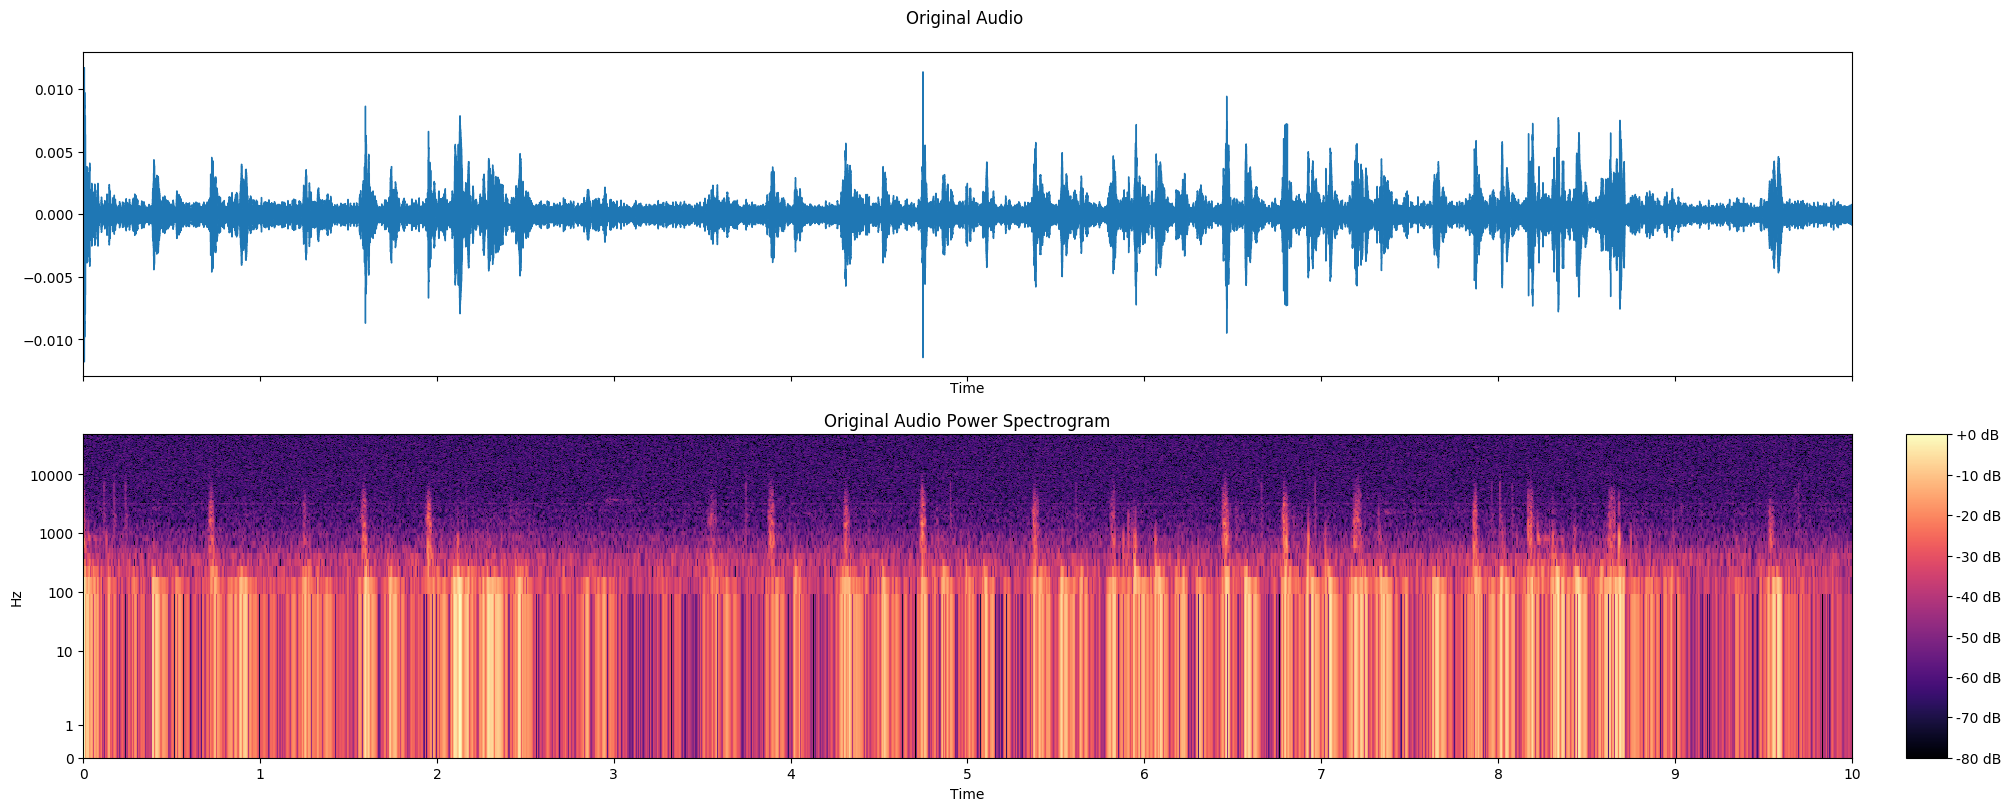

In [19]:
show_audio_spectral(raw_sample, title="Original Audio", figsize=(20, 8))

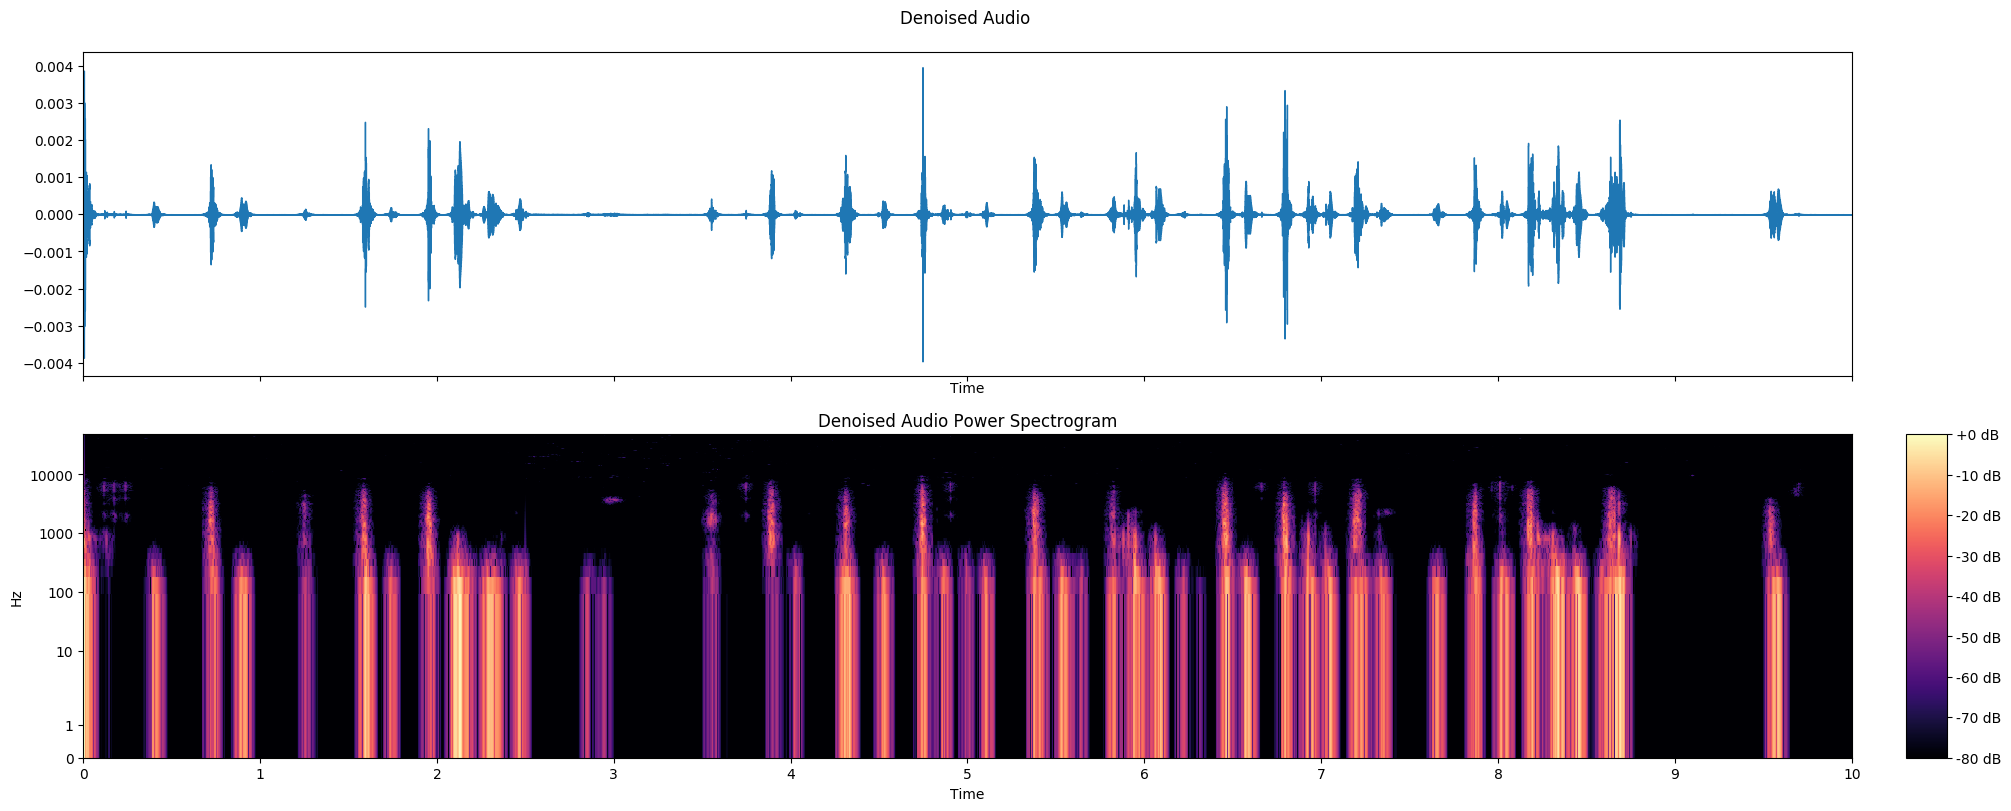

In [20]:
show_audio_spectral(raw_sample_denoised, title="Denoised Audio", figsize=(20, 8)) 

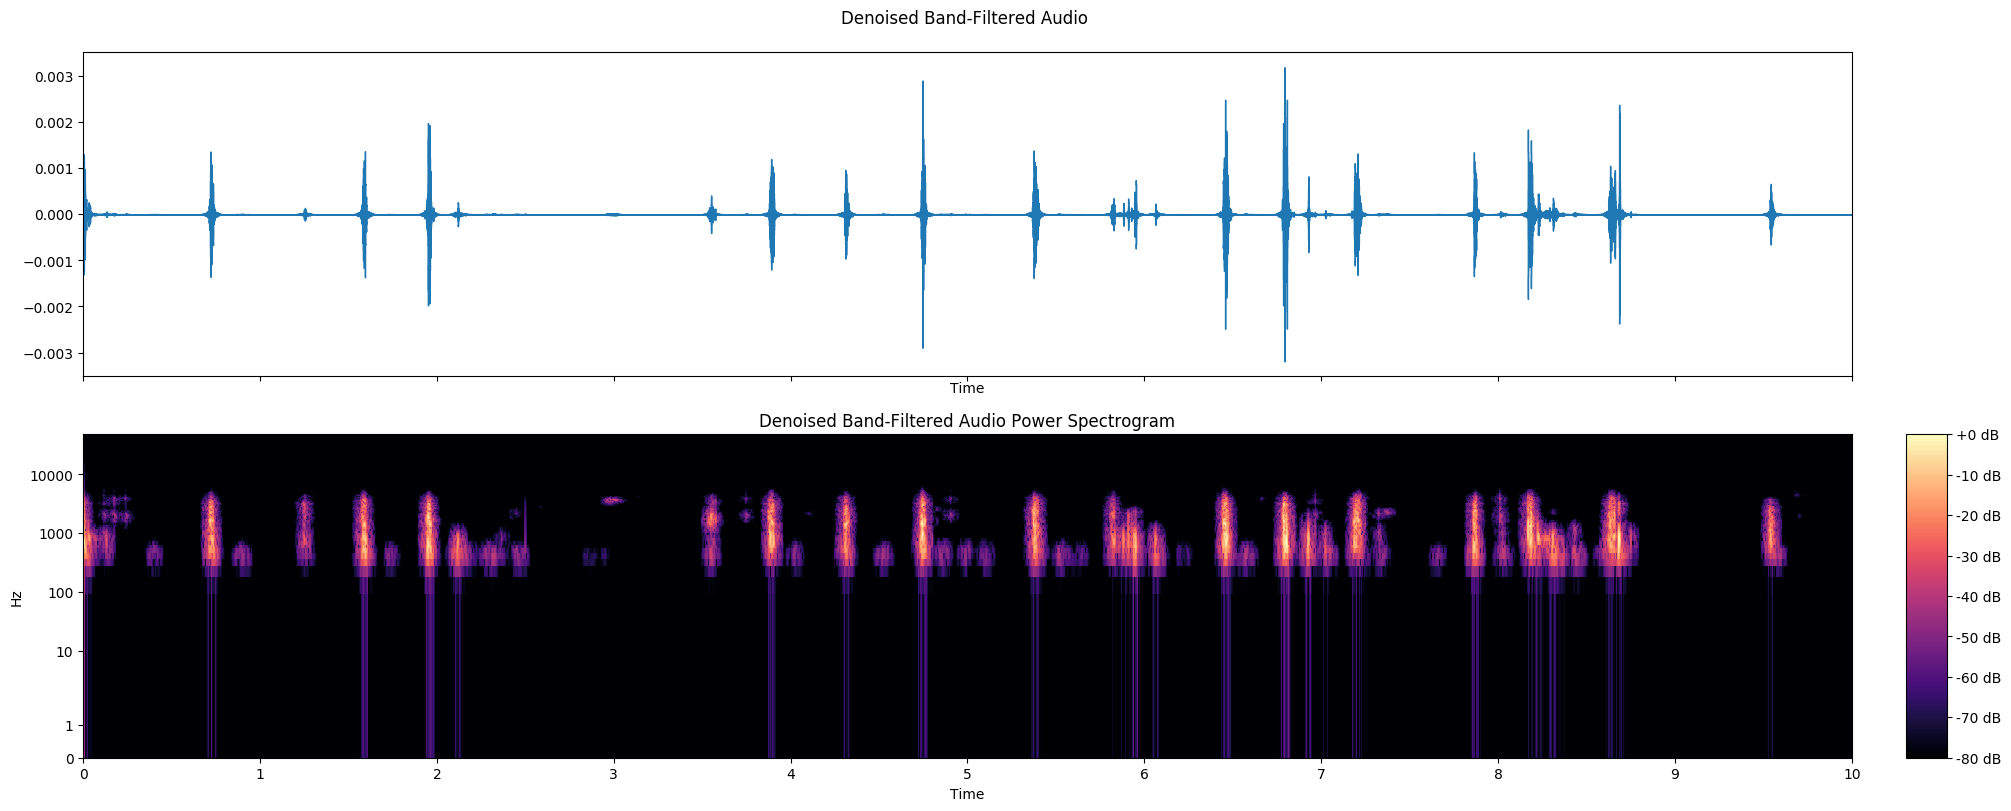

In [21]:
show_audio_spectral(raw_sample_denoised_filtered, title="Denoised Band-Filtered Audio", figsize=(20, 8)) 

In [22]:
vis_sample_index = 15

Class:Pecking N-Samples: 1949
Class:Others N-Samples: 1370


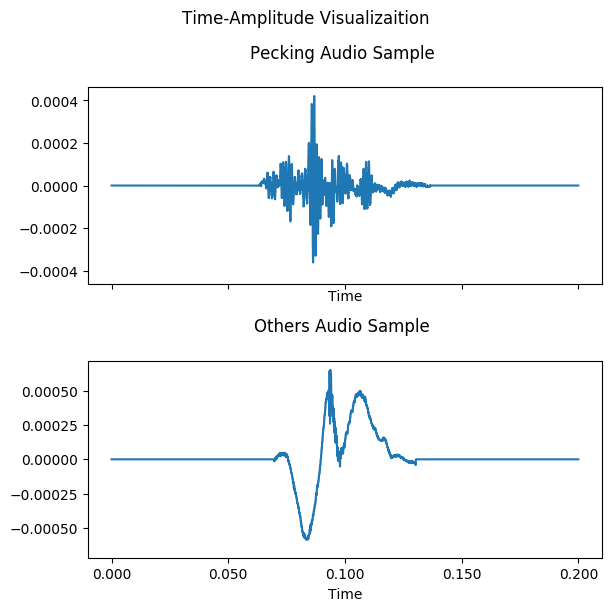

In [23]:
fig, axs = plt.subplots(len(dataset.keys()),figsize=(6, 6), sharex=True,constrained_layout = True) 
 
fig.suptitle('Time-Amplitude Visualizaition')

for idx, dataclass in enumerate(dataset.keys()):
    print(f"Class:{dataclass} N-Samples: {len(dataset[dataclass])}")  
    axs[idx].title.set_text(f"{dataclass} Audio Sample \n")
    librosa.display.waveshow(dataset[dataclass][vis_sample_index], sr=SAMPLING_RATE, ax = axs[idx])

plt.savefig('audio_temporal_labeled_sample.png', transparent=True) 
plt.show()

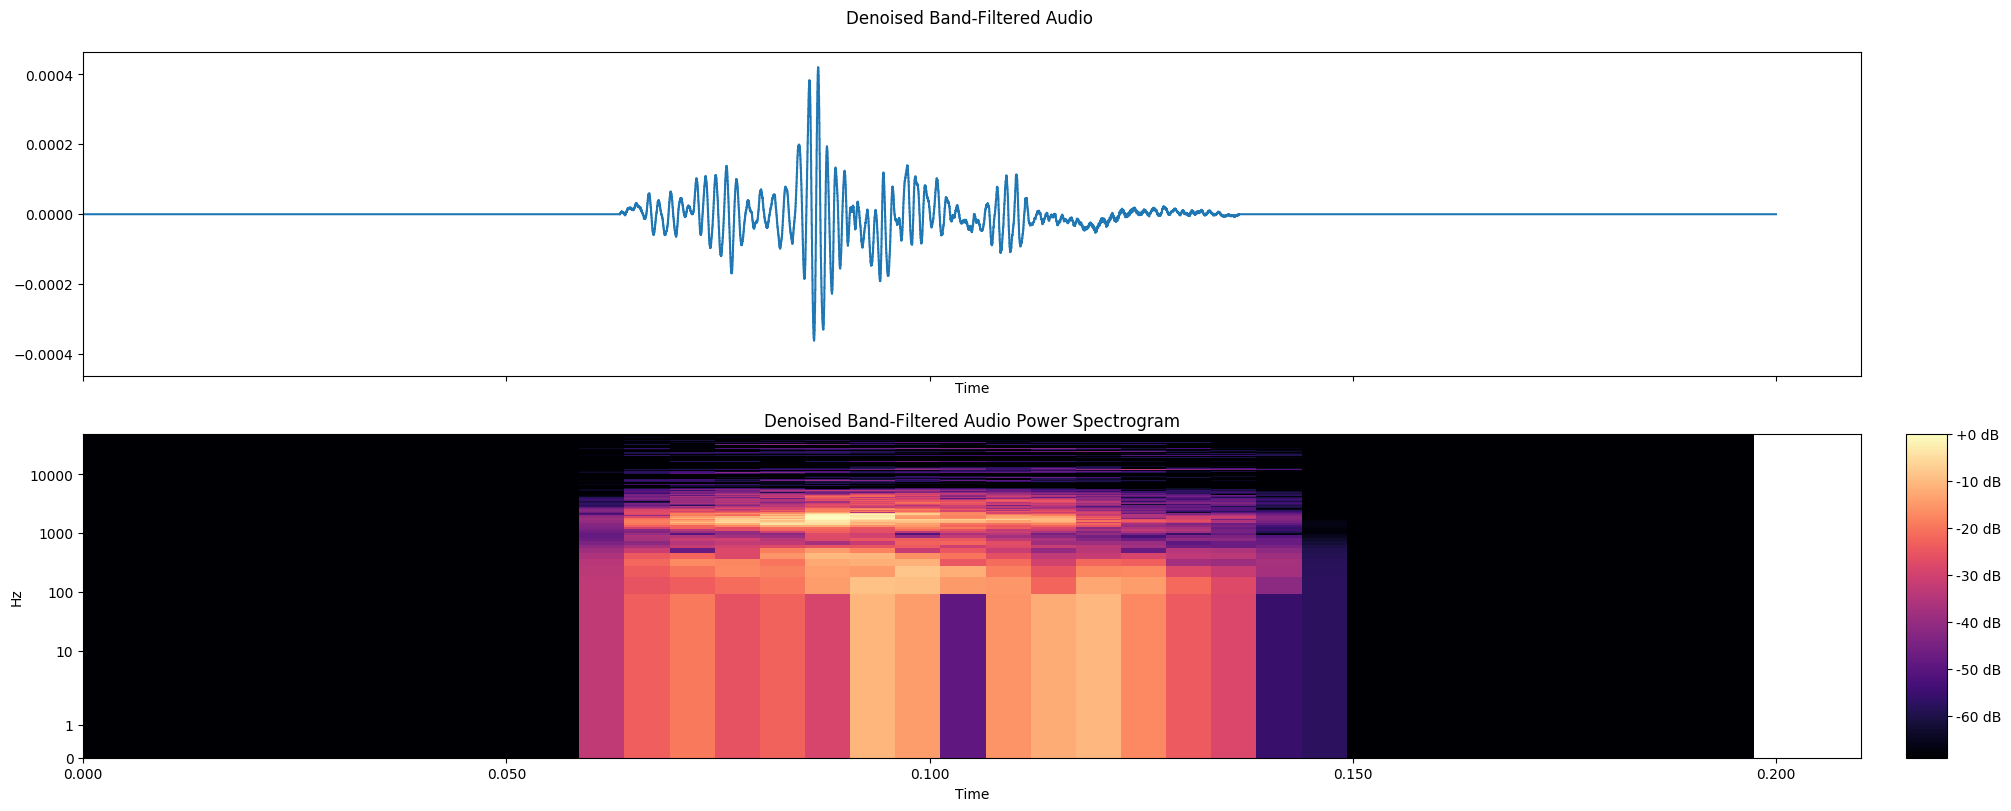

In [24]:
show_audio_spectral(dataset["Pecking"][15], title="Denoised Band-Filtered Audio", figsize=(20, 8)) 

In [25]:
Audio(dataset["Others"][22]*10,rate=SAMPLING_RATE)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp

def get_signal_envelop(wave_sample, N=None):
    analytic_signal = hilbert(wave_sample,N= N)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

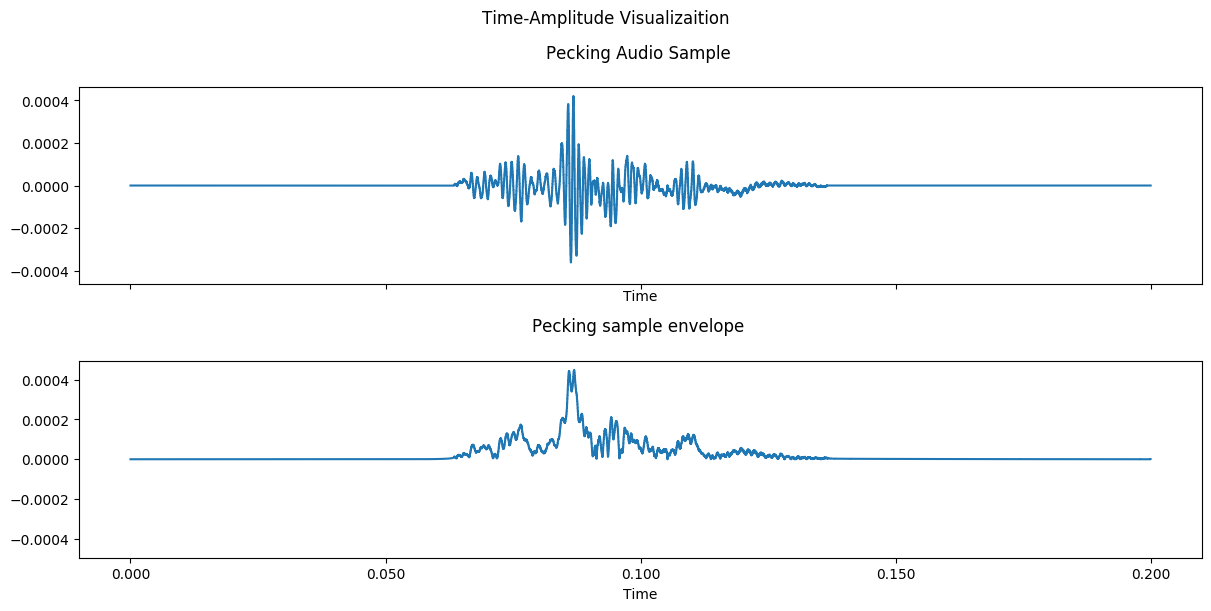

(9600,)

In [27]:
visualization_sample = dataset["Pecking"][vis_sample_index]
 
envelope = get_signal_envelop(visualization_sample)

fig, axs = plt.subplots(2,figsize=(12, 6), sharex=True,constrained_layout = True) 
 
fig.suptitle('Time-Amplitude Visualizaition')

axs[0].title.set_text(f"Pecking Audio Sample \n")
librosa.display.waveshow(visualization_sample, sr=SAMPLING_RATE, ax = axs[0])

axs[1].title.set_text(f"Pecking sample envelope \n")
_ = librosa.display.waveshow(envelope, sr=SAMPLING_RATE, ax = axs[1])
plt.savefig('audio_temporal_labeled_sample_envelope.png', transparent=True) 
plt.show()
envelope.shape

### Feeature Extraction

In [28]:
def get_spect(wave_sample,n_fft=FFT_SIZE):

    return librosa.amplitude_to_db(np.abs(librosa.stft(y=wave_sample,n_fft=FFT_SIZE)), ref=np.max)

In [29]:
def get_zero_crossing_features(wave_sample):
    crossings = np.nonzero(librosa.zero_crossings(wave_sample))[0]
    number_of_zero_crossings = len(crossings)
    mean_zero_crossing_rate = librosa.feature.zero_crossing_rate(wave_sample).mean()
    
    return number_of_zero_crossings, mean_zero_crossing_rate

In [30]:
def get_mean_flatness(audio_sample):
    return librosa.feature.spectral_flatness(y=audio_sample).mean()

In [31]:
def get_time_domain_features(wave_sample):
    features = []
    number_of_zero_crossings , mean_zero_crossing_rate = get_zero_crossing_features(wave_sample)
    features.append(number_of_zero_crossings)
    features.append(mean_zero_crossing_rate)
    features.append(wave_sample.max())
    features.append(wave_sample.min())
    features.append(np.var(wave_sample))
    features.append(sc.stats.kurtosis(wave_sample))
    features.append(sc.stats.skew(wave_sample))
    features.append(maad.features.roughness(wave_sample))
    
    return np.array(features)


In [32]:
targets = [] 
freq_features = []
time_features = []
time_manual_features = []

for idx, dataclass in enumerate(dataset.keys()):
    for sample in dataset[dataclass]:

        targets.append(dataclass)
        spect = get_spect(sample,)
        spect = spect.reshape(spect.shape[0], spect.shape[1], 1)
        freq_features.append(spect)
 
        envelope = get_signal_envelop(sample)
        envelope = envelope.reshape(envelope.shape[0], 1)       
        time_features.append(envelope)

        
        time_manual_features.append(get_time_domain_features(sample))

freq_features = np.array(freq_features)        
time_features = np.array(time_features)
time_manual_features = np.array(time_manual_features)

In [33]:
spec_shape = spect.shape
spec_shape

(513, 38, 1)

In [34]:
envelope_shape = envelope.shape
envelope_shape

(9600, 1)

In [35]:
time_manual_features.shape

(3319, 8)

In [36]:
from sklearn.preprocessing import OneHotEncoder
target_encoder = OneHotEncoder(sparse_output=False)
np_target = np.array(targets).reshape(-1, 1)
target_encoder.fit(np_target)
one_hot_y = target_encoder.transform(np_target)
one_hot_y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [37]:
def normalize(values, min_val=0, max_val=0):
    
    if min_val==0 or max_val==0:
        
        min_val = values.min()
        max_val = values.max()
    normalized_values = (values - min_val)/(max_val - min_val)
    return normalized_values, min_val, max_val

freq_features, freq_min, freq_max = normalize(freq_features)
time_features, time_min, time_max = normalize(time_features)
time_manual_features, time_man_min, time_man_max = normalize(time_manual_features)

In [38]:
from sklearn.model_selection import train_test_split
xtrain_freq, xtest_freq, xtrain_time, xtest_time, xtrain_time_manual, xtest_time_manual, ytrain, ytest,ytrain_categorical, ytest_categorical = train_test_split(freq_features,
    time_features,
    time_manual_features,
    one_hot_y,
    np_target,
    train_size=0.7,random_state=11)

print("Spectral Features")
print(xtrain_freq.shape)
print(xtest_freq.shape)

print("Temporal Features")
print(xtrain_time.shape)
print(xtest_time.shape)

print("Temporal Hard-Coded Features")
print(xtrain_time_manual.shape)
print(xtest_time_manual.shape)

print("One-Hot Encoded Target Features")
print(ytrain.shape)
print(ytest.shape)

Spectral Features
(2323, 513, 38, 1)
(996, 513, 38, 1)
Temporal Features
(2323, 9600, 1)
(996, 9600, 1)
Temporal Hard-Coded Features
(2323, 8)
(996, 8)
One-Hot Encoded Target Features
(2323, 2)
(996, 2)


In [39]:
ytrain_categorical = ytrain_categorical.ravel() 
ytest_categorical = ytest_categorical.ravel() 

### Baseline Model

In [40]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import AdaBoostClassifier

 

### Training Classic Machine Learning Models

10-Fold CV Score :0.790 ± 0.018


Test Statistics:
              precision    recall  f1-score   support

      Others       0.85      0.67      0.75       424
     Pecking       0.79      0.91      0.85       572

    accuracy                           0.81       996
   macro avg       0.82      0.79      0.80       996
weighted avg       0.82      0.81      0.80       996



Balanced Testing Accuracy:0.791


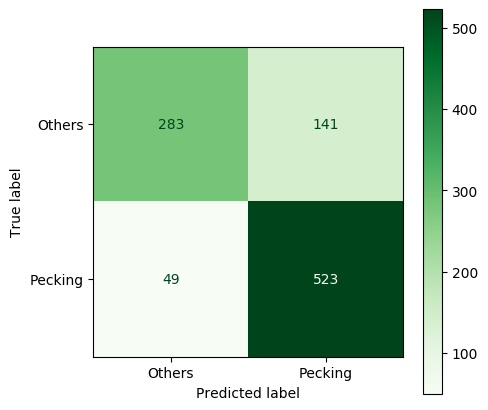

In [41]:
 
model = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
#model = Pipeline([('scaler', StandardScaler()), ('svc', SVC(C=5.0, degree=2))])

model.fit(xtrain_time_manual, ytrain_categorical)
model_scores = cross_val_score(model, xtrain_time_manual, ytrain_categorical, cv=10,scoring="balanced_accuracy")
print(f'10-Fold CV Score :{model_scores.mean():.3f} ± {model_scores.std():.3f}', sep='\n', end='\n\n\n')


model_ypred = model.predict(xtest_time_manual)
model_cr = classification_report(ytest_categorical, model_ypred)

print('Test Statistics:', model_cr, sep='\n', end='\n\n\n')

model_accuracy = balanced_accuracy_score(ytest_categorical, model_ypred)
print(f'Balanced Testing Accuracy:{model_accuracy:.3f}')


fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
ConfusionMatrixDisplay.from_estimator(model, xtest_time_manual, ytest_categorical,ax = ax, cmap='Greens')
plt.show()
 

In [42]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

classes = [key for key in dataset.keys()]

def plot_multiclass_auroc(onehot_ytest, onehot_ypredicted, classes, title="No Title"):
    
    num_of_classes = len(classes)
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest.ravel(), predicted_y.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")
    
    for i in range(num_of_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest[:, i], predicted_y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(num_of_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= num_of_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    
    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=2,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="brown",
        linestyle=":",
        linewidth=2,
    )

    colors = cycle(["darkgreen", "darkorange", "darkblue", "red"])
    for class_id, color in zip(range(num_of_classes), colors):
        RocCurveDisplay.from_predictions(
            ytest[:, class_id],
            predicted_y[:, class_id],
            name=f"ROC curve for {classes[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

### Training a Deep Conv Neural Network with Spectral Features

In [43]:
def plot_model_results(history, title="No Title", no_loss=True):
    
    if no_loss: 
        fig, accuracy_plot = plt.subplots(figsize=(6, 4))
        fig.suptitle(title)
    else: 
        
        fig, (accuracy_plot, loss_plot) = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(title)
 
    # summarize history for accuracy
    accuracy_plot.plot(history.history['accuracy'])
    accuracy_plot.plot(history.history['val_accuracy'])
    #accuracy_plot.set_title('model accuracy')
    accuracy_plot.set_ylabel('accuracy')
    accuracy_plot.set_xlabel('epoch')
    accuracy_plot.legend(['Train', 'Validation'], loc='upper left')
    
    if not no_loss: 
    # summarize history for loss
        loss_plot.plot(history.history['loss'])
        loss_plot.plot(history.history['val_loss'])
        loss_plot.set_title('model loss')
        loss_plot.set_ylabel('loss')
        loss_plot.set_xlabel('epoch')
        loss_plot.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'{title}.png', transparent=True)
        
    plt.savefig(f'{title}.png', transparent=True)
    plt.show()

In [44]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [45]:
inputs = keras.Input(shape=spec_shape, name="img")

model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(inputs)
model_2D = layers.MaxPooling2D(3)(model_2D)

model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(model_2D)
model_2D = layers.MaxPooling2D(3, padding="same")(model_2D)

model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(model_2D)
model_2D = layers.MaxPooling2D(3, padding="same")(model_2D)

model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(model_2D)
model_2D = layers.MaxPooling2D(3, padding="same")(model_2D)

model_2D = layers.Conv2D(16, 3, activation="relu", padding="same")(model_2D)
model_2D = layers.GlobalAveragePooling2D()(model_2D)

dense = tf.keras.layers.Dense(32, activation='relu')(model_2D)
dense = layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
dense = layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(num_of_classes, activation='softmax')(dense)

spectral_model = tf.keras.Model(inputs = inputs, outputs = [dense, ])

spectral_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 513, 38, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 513, 38, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 171, 12, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 171, 12, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 4, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 4, 32)         9248  

In [46]:
def scheduler(epoch, lr):
    if epoch == 15 or epoch == 20:
        return lr * 0.1
    else:
        return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/25
78/78 [==============================] - 4s 11ms/step - loss: 0.6282 - accuracy: 0.6737 - val_loss: 0.4626 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 2/25
78/78 [==============================] - 0s 6ms/step - loss: 0.5307 - accuracy: 0.7873 - val_loss: 0.4004 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 3/25
78/78 [==============================] - 0s 6ms/step - loss: 0.4559 - accuracy: 0.8149 - val_loss: 0.4343 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 4/25
78/78 [==============================] - 1s 7ms/step - loss: 0.4309 - accuracy: 0.8278 - val_loss: 0.3295 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 5/25
78/78 [==============================] - 0s 6ms/step - loss: 0.3578 - accuracy: 0.8683 - val_loss: 0.3001 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 6/25
78/78 [==============================] - 1s 6ms/step - loss: 0.3352 - accuracy: 0.8790 - val_loss: 0.3125 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 7/25
78/78 [==============================] - 1s 7ms/step - loss: 0.2945 - 

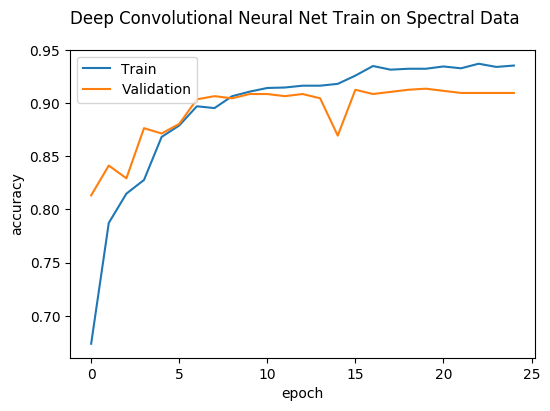

In [47]:
opt = optimizers.Adam(learning_rate=0.001)
spectral_model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

spectral_model_history = spectral_model.fit(xtrain_freq, ytrain,
                                                    validation_data=(xtest_freq, ytest),
                                                    epochs=25, batch_size=30,verbose=True, callbacks=[lr_callback,model_checkpoint_callback])

plot_model_results(spectral_model_history, title="Deep Convolutional Neural Net Train on Spectral Data")

32/32 [==============================] - 0s 3ms/step

 Balanced Testing Accuracy: 0.9088187755640587
Test Statistics:
              precision    recall  f1-score   support

      Others       0.89      0.90      0.89       424
     Pecking       0.93      0.91      0.92       572

    accuracy                           0.91       996
   macro avg       0.91      0.91      0.91       996
weighted avg       0.91      0.91      0.91       996





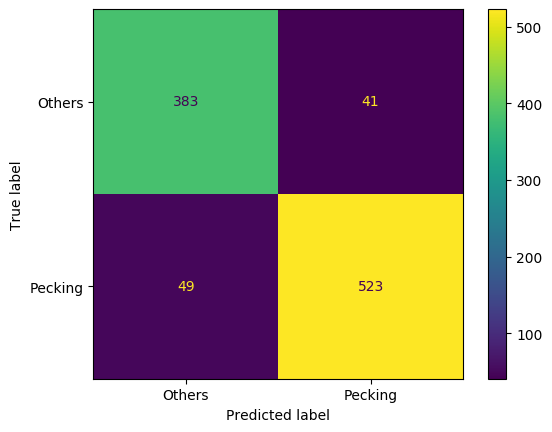

In [48]:
predicted_y = spectral_model.predict(xtest_freq)
predicted_y_reversed = target_encoder.inverse_transform(predicted_y)
test_y_reversed = target_encoder.inverse_transform(ytest)
acuracy = balanced_accuracy_score(test_y_reversed, predicted_y_reversed)
 
print("\n Balanced Testing Accuracy:", acuracy)
model_cr = classification_report(test_y_reversed, predicted_y_reversed)

print('Test Statistics:', model_cr, sep='\n', end='\n\n\n')

cm = confusion_matrix(test_y_reversed, predicted_y_reversed, labels=target_encoder.categories_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_encoder.categories_[0])
disp.plot()
plt.savefig('model_confusion.png', transparent=True) 
plt.show()

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


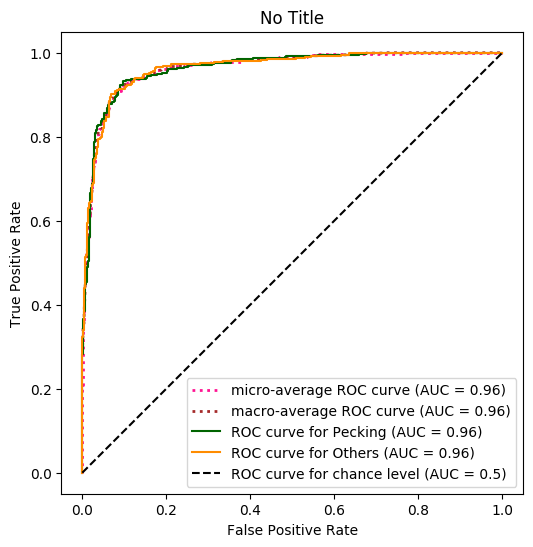

In [49]:
plot_multiclass_auroc(ytest,predicted_y,classes)

In [50]:
# def scheduler(epoch, lr):
#     if epoch < 30:
#         return lr   
#     else:
#         return lr * tf.math.exp(-0.1)

# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Training a model based on both Spectral and Temporal Features 

In [51]:
in_1D = keras.Input(envelope_shape)

model_1D = Conv1D(32, kernel_size= 21 , strides=11, activation='relu',padding="same")(in_1D)
model_1D = AveragePooling1D(pool_size= 8, strides=4)(model_1D)

model_1D = Conv1D(32, kernel_size= 11 , strides=5, activation='relu',padding="same")(model_1D)
model_1D = AveragePooling1D(pool_size= 4, strides=2)(model_1D)

model_1D = Conv1D(32, kernel_size= 7 , strides=3, activation='relu',padding="same")(model_1D)
model_1D = AveragePooling1D(pool_size= 2, strides=1)(model_1D)

model_1D = Conv1D(32, kernel_size= 5 , strides=2, activation='relu',padding="same")(model_1D)
model_1D = GlobalMaxPooling1D()(model_1D)

model_1D = Flatten()(model_1D)

# ----------------------- 2D CNN ----------------------
in_2D = keras.Input(spec_shape)


model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(in_2D)
model_2D = layers.MaxPooling2D(3, padding="same")(model_2D)

model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(model_2D)
model_2D = layers.MaxPooling2D(3, padding="same")(model_2D)

model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(model_2D)
model_2D = layers.MaxPooling2D(3, padding="same")(model_2D)

model_2D = layers.Conv2D(32, 3, activation="relu",padding="same")(model_2D)
model_2D = layers.MaxPooling2D(3, padding="same")(model_2D)

model_2D = layers.Conv2D(32, 3, activation="relu", padding="same")(model_2D)
model_2D = layers.GlobalMaxPooling2D()(model_2D)

model_2D = Flatten()(model_2D)

merged = Concatenate()([model_2D, model_1D])

dense = Dense(32, activation='relu')(merged)
dense = layers.Dropout(0.5)(dense)

dense = Dense(16, activation='relu')(dense)
dense = layers.Dropout(0.5)(dense)
output = Dense(num_of_classes, activation='softmax')(dense)

model_combined = Model(inputs=[in_2D, in_1D], outputs=[output])
model_combined.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 513, 38, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 513, 38, 32)  320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 171, 13, 32)  0          ['conv2d_5[0][0]']               
                                                                                                  
 input_1 (InputLayer)           [(None, 9600, 1)]    0           []                         

In [52]:
def scheduler(epoch, lr):
    if epoch == 15 or  epoch == 20:
        return lr * 0.1  
    else:
        return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/25
59/59 [==============================] - 2s 15ms/step - loss: 0.6001 - accuracy: 0.6827 - val_loss: 0.4241 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 2/25
59/59 [==============================] - 1s 9ms/step - loss: 0.4654 - accuracy: 0.7843 - val_loss: 0.3837 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 3/25
59/59 [==============================] - 1s 9ms/step - loss: 0.4123 - accuracy: 0.8218 - val_loss: 0.3231 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 4/25
59/59 [==============================] - 1s 9ms/step - loss: 0.3568 - accuracy: 0.8622 - val_loss: 0.4360 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 5/25
59/59 [==============================] - 1s 9ms/step - loss: 0.4078 - accuracy: 0.8541 - val_loss: 0.2820 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 6/25
59/59 [==============================] - 0s 8ms/step - loss: 0.3273 - accuracy: 0.8790 - val_loss: 0.2749 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 7/25
59/59 [==============================] - 1s 9ms/step - loss: 0.2833 - 

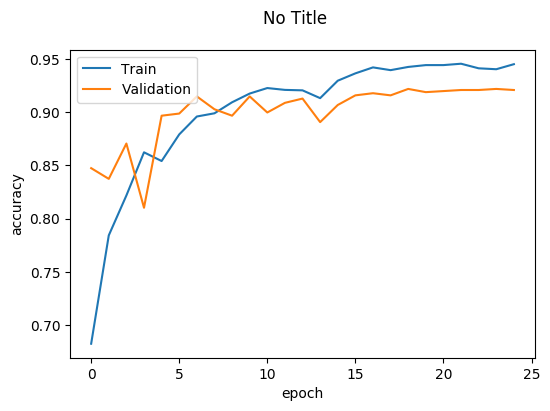

In [53]:
opt = optimizers.Adam(learning_rate=0.001)

model_combined.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model_combined.fit(x=[xtrain_freq, xtrain_time], y=ytrain,
                                                    validation_data=([xtest_freq, xtest_time], ytest),
                                                    epochs=25, batch_size=40,verbose=True, callbacks=[lr_callback, model_checkpoint_callback])
plot_model_results(history)

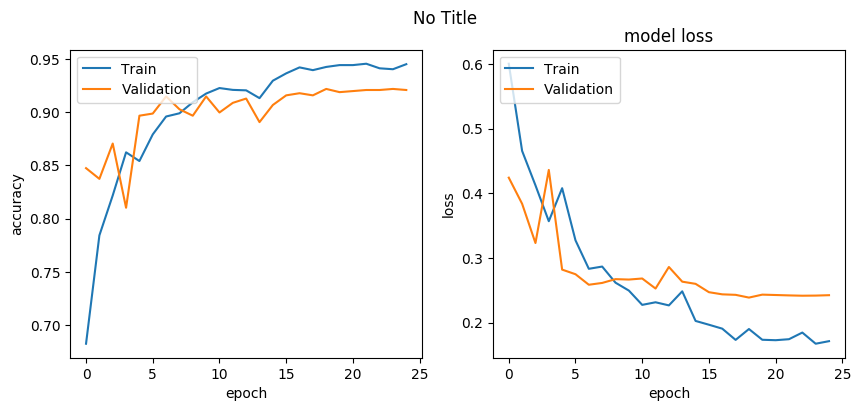

In [54]:
plot_model_results(history,no_loss=False) 

32/32 [==============================] - 0s 3ms/step

 Balanced Testing Accuracy: 0.9202648766328012
Test Statistics:
              precision    recall  f1-score   support

      Others       0.90      0.92      0.91       424
     Pecking       0.94      0.92      0.93       572

    accuracy                           0.92       996
   macro avg       0.92      0.92      0.92       996
weighted avg       0.92      0.92      0.92       996





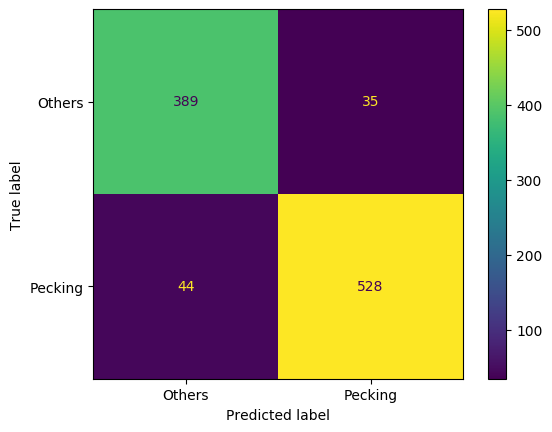

In [55]:
predicted_y = model_combined.predict([xtest_freq,xtest_time])
predicted_y_reversed = target_encoder.inverse_transform(predicted_y)
test_y_reversed = target_encoder.inverse_transform(ytest)
acuracy = balanced_accuracy_score(test_y_reversed, predicted_y_reversed)
print("\n Balanced Testing Accuracy:", acuracy)
model_cr = classification_report(test_y_reversed, predicted_y_reversed)

print('Test Statistics:', model_cr, sep='\n', end='\n\n\n')
cm = confusion_matrix(test_y_reversed, predicted_y_reversed, labels=target_encoder.categories_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_encoder.categories_[0],)
disp.plot()
plt.show()

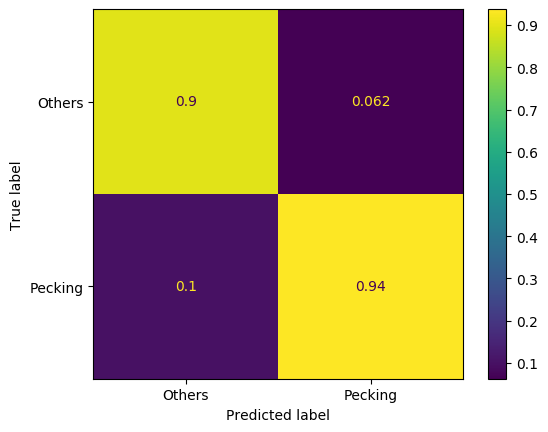

In [56]:
cm = confusion_matrix(test_y_reversed, predicted_y_reversed, labels=target_encoder.categories_[0],normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_encoder.categories_[0],)
disp.plot()
plt.show()

Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.97


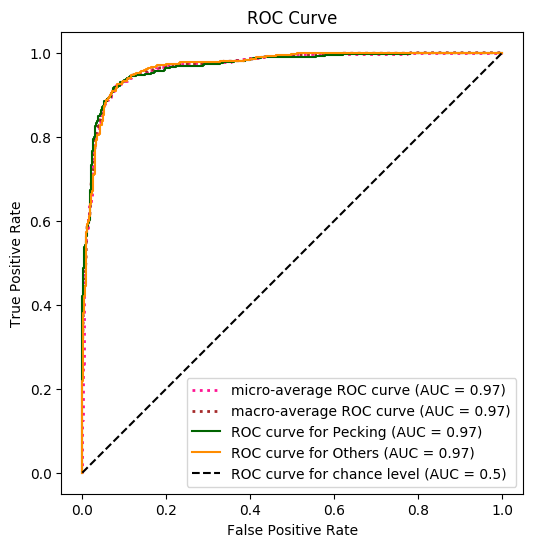

In [57]:
plot_multiclass_auroc(ytest,predicted_y,classes,title="ROC Curve")

### Processing One Week Raw Data

In [58]:
#finding ROIs for classification on a sample audio recording 

files_names = sorted(getfiles(raw_data_path, pattern="*.wav"))
len(files_names)

1798

In [59]:
def extract_rois(sample, flims, tlen):
    extracted_rois = rois.find_rois_cwt(sample, SAMPLING_RATE, flims=flims, tlen=tlen, th=0, display=False)
    return extracted_rois

### Testing model performance on a part of the actual dataset

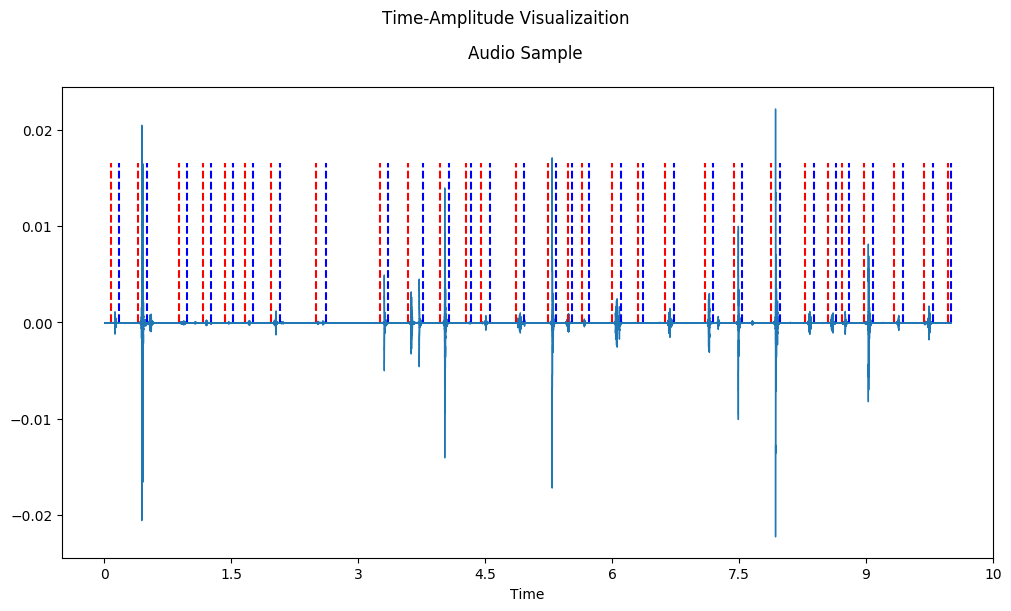

In [60]:
full_sample_index = 30

filename, visualization_fullsample= load_wave_file(files_names[full_sample_index])
 
visualization_fullsample = visualization_fullsample[(60*5)*SAMPLING_RATE:(60*5+10)*SAMPLING_RATE]
noise_removed = nr.reduce_noise(y=visualization_fullsample, sr=SAMPLING_RATE)
noise_removed_filtered = maad.sound.select_bandwidth(noise_removed,SAMPLING_RATE,fcut=(low_band,high_band), forder=5, fname ='butter', ftype='bandpass')
fig, axs = plt.subplots(1, figsize=(10, 6), sharex=True,constrained_layout = True) 
 
fig.suptitle('Time-Amplitude Visualizaition')

axs.title.set_text(f"Audio Sample \n")
librosa.display.waveshow(noise_removed_filtered, sr=SAMPLING_RATE, ax = axs)

extracted_rois = extract_rois(noise_removed_filtered, flims=(low_band,high_band), tlen=0.10)
onset_times_ids = extracted_rois["min_t"]
offset_times_ids = extracted_rois["max_t"]
axs.vlines(onset_times_ids,
           0, noise_removed_filtered.max(),
           label='Raw onsets', linestyle='--', color='r')

axs.vlines(offset_times_ids,
           0, noise_removed_filtered.max(),
           label='Raw onsets', linestyle='--', color='b')

plt.savefig('signal_rois.png', transparent=True) 
plt.show()


In [61]:
#extracted_rois = extract_rois(noise_removed_filtered, flims=(low_band,high_band), tlen=0.12)
specs = []
envelopes=[]
for i in range(len(onset_times_ids)):
    start = int(onset_times_ids[i]*SAMPLING_RATE)
    end = int(offset_times_ids[i]*SAMPLING_RATE)
     
    extracted_roi = noise_removed_filtered[start:end]
    if extracted_roi.shape[0]>window_size:
        continue
    extracted_roi= librosa.util.pad_center(extracted_roi, size=window_size)
    
    spect = get_spect(extracted_roi,).reshape(spec_shape)
    
    specs.append(spect)
    
    envelope = get_signal_envelop(extracted_roi).reshape(envelope_shape)
    envelopes.append(envelope)

    #time_manual_features, time_man_min, time_man_max = normalize(time_manual_features)


specs = np.array(specs)
envelopes = np.array(envelopes)


specs, freq_min, freq_max = normalize(specs,freq_min, freq_max)
envelopes, time_min, time_max = normalize(envelopes,time_min, time_max)

predicted_y = spectral_model.predict([specs])  
 
predicted_y_reversed = target_encoder.inverse_transform(predicted_y)
print(predicted_y_reversed)

1/1 [==============================] - 0s 57ms/step
[['Pecking']
 ['Pecking']
 ['Pecking']
 ['Others']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Others']
 ['Pecking']
 ['Others']
 ['Pecking']
 ['Others']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Others']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']
 ['Pecking']]


In [62]:
values, counts = np.unique(predicted_y_reversed, return_counts=True)
list(zip(values, counts))

[('Others', 5), ('Pecking', 25)]

In [63]:
#loading list of files 
#loading each file
#segment the 
from IPython.display import Audio
Audio(noise_removed*10,rate=SAMPLING_RATE)


In [64]:
from datetime import datetime
from dataclasses import make_dataclass

events_list = []
events_list.append(("Time", datetime))

for key in dataset.keys():
    events_list.append((key, int))

TimePecking = make_dataclass("TimePecking", events_list)

In [65]:
def extract_datetime(strdatetime):
    time_splited = strdatetime.split("_")
    time_stamp = datetime(year = int(time_splited[0]),
                          month = int(time_splited[1]),
                          day = int(time_splited[2]),
                          hour = int(time_splited[3]),
                          minute = int(time_splited[4]),
                          second = int(time_splited[5]))
    return time_stamp

In [66]:
print(len(files_names))

1798


In [67]:
from timebudget import timebudget
datapoints = []
with timebudget("Loading and processing the file"):
    for filepath in tqdm(files_names):
        #print(filepath)
        file_stats = os.stat(filepath)
        file_size_mb = file_stats.st_size/(1024*1024)
        #print(file_size_mb)
        if file_size_mb < 1.0:
            continue
        filename, visualization_fullsample= load_wave_file(filepath)
        noise_removed = nr.reduce_noise(y=visualization_fullsample, sr=SAMPLING_RATE)
        noise_removed_filtered = maad.sound.select_bandwidth(noise_removed,SAMPLING_RATE,fcut=(low_band,high_band), forder=5, fname ='butter', ftype='bandpass')
        extracted_rois = extract_rois(noise_removed_filtered, flims=(low_band,high_band), tlen=0.15)
        onset_times_ids = extracted_rois["min_t"]
        offset_times_ids = extracted_rois["max_t"]
        #print(len(offset_times_ids))
        specs = []
        envelopes=[]
        for i in range(len(onset_times_ids)):
            start = int(onset_times_ids[i]*SAMPLING_RATE)
            end = int(offset_times_ids[i]*SAMPLING_RATE)

            extracted_roi = noise_removed_filtered[start:end]
            if extracted_roi.shape[0]>window_size:
                continue
            extracted_roi= librosa.util.pad_center(extracted_roi, size=window_size)

            spect = get_spect(extracted_roi,).reshape(spec_shape)

            specs.append(spect)

            envelope = get_signal_envelop(extracted_roi).reshape(envelope_shape)
            envelopes.append(envelope)

        #time_manual_features, time_man_min, time_man_max = normalize(time_manual_features)


        specs = np.array(specs)
        envelopes = np.array(envelopes)
        specs, freq_min, freq_max = normalize(specs,freq_min, freq_max)
        envelopes, time_min, time_max = normalize(envelopes,time_min, time_max)

        predicted_y = model_combined.predict([specs,envelopes],verbose=False)
        predicted_y_reversed = target_encoder.inverse_transform(predicted_y)
        values, counts = np.unique(predicted_y_reversed, return_counts=True)
        packed_results = dict(zip(values,counts))

        for class_name in dataset.keys():
            if class_name not in packed_results:
                packed_results[class_name] = 0 

        frame_record = TimePecking(extract_datetime(filename),**packed_results)
        datapoints.append(frame_record)
        print(frame_record)


  0%|          | 0/1798 [00:00<?, ?it/s]

TimePecking(Time=datetime.datetime(2023, 2, 23, 0, 0, 2), Pecking=0, Others=2385)
TimePecking(Time=datetime.datetime(2023, 2, 23, 0, 15, 2), Pecking=1, Others=2393)
TimePecking(Time=datetime.datetime(2023, 2, 23, 0, 30, 2), Pecking=5, Others=2342)
TimePecking(Time=datetime.datetime(2023, 2, 23, 0, 45, 2), Pecking=0, Others=2359)
TimePecking(Time=datetime.datetime(2023, 2, 23, 1, 0, 2), Pecking=2, Others=2435)
TimePecking(Time=datetime.datetime(2023, 2, 23, 1, 15, 2), Pecking=1, Others=2371)
TimePecking(Time=datetime.datetime(2023, 2, 23, 1, 30, 2), Pecking=5, Others=2350)
TimePecking(Time=datetime.datetime(2023, 2, 23, 1, 45, 2), Pecking=1, Others=2415)
TimePecking(Time=datetime.datetime(2023, 2, 23, 2, 0, 2), Pecking=5, Others=2392)
TimePecking(Time=datetime.datetime(2023, 2, 23, 2, 15, 2), Pecking=3, Others=2419)
TimePecking(Time=datetime.datetime(2023, 2, 23, 2, 30, 2), Pecking=0, Others=2440)
TimePecking(Time=datetime.datetime(2023, 2, 23, 2, 45, 2), Pecking=0, Others=2406)
TimePec

TimePecking(Time=datetime.datetime(2023, 2, 24, 0, 45, 2), Pecking=2, Others=2400)
TimePecking(Time=datetime.datetime(2023, 2, 24, 1, 0, 2), Pecking=3, Others=2347)
TimePecking(Time=datetime.datetime(2023, 2, 24, 1, 15, 2), Pecking=0, Others=2340)
TimePecking(Time=datetime.datetime(2023, 2, 24, 1, 30, 2), Pecking=1, Others=2400)
TimePecking(Time=datetime.datetime(2023, 2, 24, 1, 45, 2), Pecking=2, Others=2368)
TimePecking(Time=datetime.datetime(2023, 2, 24, 2, 0, 2), Pecking=1, Others=2381)
TimePecking(Time=datetime.datetime(2023, 2, 24, 2, 15, 2), Pecking=3, Others=2457)
TimePecking(Time=datetime.datetime(2023, 2, 24, 2, 30, 2), Pecking=0, Others=2383)
TimePecking(Time=datetime.datetime(2023, 2, 24, 2, 45, 2), Pecking=2, Others=2385)
TimePecking(Time=datetime.datetime(2023, 2, 24, 3, 0, 2), Pecking=21, Others=2320)
TimePecking(Time=datetime.datetime(2023, 2, 24, 3, 15, 2), Pecking=6, Others=2392)
TimePecking(Time=datetime.datetime(2023, 2, 24, 3, 30, 2), Pecking=1, Others=2388)
TimePe

TimePecking(Time=datetime.datetime(2023, 2, 25, 1, 15, 2), Pecking=0, Others=2365)
TimePecking(Time=datetime.datetime(2023, 2, 25, 1, 30, 2), Pecking=4, Others=2383)
TimePecking(Time=datetime.datetime(2023, 2, 25, 1, 45, 2), Pecking=1, Others=2397)
TimePecking(Time=datetime.datetime(2023, 2, 25, 2, 0, 2), Pecking=3, Others=2371)
TimePecking(Time=datetime.datetime(2023, 2, 25, 2, 15, 2), Pecking=3, Others=2336)
TimePecking(Time=datetime.datetime(2023, 2, 25, 2, 30, 2), Pecking=0, Others=2417)
TimePecking(Time=datetime.datetime(2023, 2, 25, 2, 45, 2), Pecking=1, Others=2350)
TimePecking(Time=datetime.datetime(2023, 2, 25, 3, 0, 2), Pecking=2, Others=2372)
TimePecking(Time=datetime.datetime(2023, 2, 25, 3, 15, 2), Pecking=2, Others=2386)
TimePecking(Time=datetime.datetime(2023, 2, 25, 3, 30, 2), Pecking=2, Others=2352)
TimePecking(Time=datetime.datetime(2023, 2, 25, 3, 45, 2), Pecking=0, Others=2348)
TimePecking(Time=datetime.datetime(2023, 2, 25, 4, 0, 2), Pecking=1, Others=2372)
TimePec

TimePecking(Time=datetime.datetime(2023, 2, 26, 1, 45, 2), Pecking=2, Others=2356)
TimePecking(Time=datetime.datetime(2023, 2, 26, 2, 0, 2), Pecking=0, Others=2411)
TimePecking(Time=datetime.datetime(2023, 2, 26, 2, 15, 2), Pecking=2, Others=2353)
TimePecking(Time=datetime.datetime(2023, 2, 26, 2, 30, 2), Pecking=2, Others=2298)
TimePecking(Time=datetime.datetime(2023, 2, 26, 2, 45, 2), Pecking=3, Others=2409)
TimePecking(Time=datetime.datetime(2023, 2, 26, 3, 0, 2), Pecking=3, Others=2361)
TimePecking(Time=datetime.datetime(2023, 2, 26, 3, 15, 2), Pecking=1, Others=2420)
TimePecking(Time=datetime.datetime(2023, 2, 26, 3, 30, 2), Pecking=3, Others=2347)
TimePecking(Time=datetime.datetime(2023, 2, 26, 3, 45, 2), Pecking=1, Others=2354)
TimePecking(Time=datetime.datetime(2023, 2, 26, 4, 0, 2), Pecking=1, Others=2393)
TimePecking(Time=datetime.datetime(2023, 2, 26, 4, 15, 2), Pecking=3, Others=2373)
TimePecking(Time=datetime.datetime(2023, 2, 26, 4, 30, 2), Pecking=1, Others=2417)
TimePec

TimePecking(Time=datetime.datetime(2023, 2, 27, 2, 15, 2), Pecking=2, Others=2329)
TimePecking(Time=datetime.datetime(2023, 2, 27, 2, 30, 2), Pecking=5, Others=2318)
TimePecking(Time=datetime.datetime(2023, 2, 27, 2, 45, 2), Pecking=2, Others=2381)
TimePecking(Time=datetime.datetime(2023, 2, 27, 3, 0, 2), Pecking=1, Others=2318)
TimePecking(Time=datetime.datetime(2023, 2, 27, 3, 15, 2), Pecking=3, Others=2354)
TimePecking(Time=datetime.datetime(2023, 2, 27, 3, 30, 2), Pecking=3, Others=2384)
TimePecking(Time=datetime.datetime(2023, 2, 27, 3, 45, 2), Pecking=3, Others=2302)
TimePecking(Time=datetime.datetime(2023, 2, 27, 4, 0, 2), Pecking=3, Others=2349)
TimePecking(Time=datetime.datetime(2023, 2, 27, 4, 15, 2), Pecking=2, Others=2361)
TimePecking(Time=datetime.datetime(2023, 2, 27, 4, 30, 2), Pecking=2, Others=2373)
TimePecking(Time=datetime.datetime(2023, 2, 27, 4, 45, 2), Pecking=2, Others=2354)
TimePecking(Time=datetime.datetime(2023, 2, 27, 5, 0, 2), Pecking=2, Others=2376)
TimePec

TimePecking(Time=datetime.datetime(2023, 2, 28, 2, 30, 2), Pecking=4, Others=2392)
TimePecking(Time=datetime.datetime(2023, 2, 28, 2, 45, 2), Pecking=2, Others=2389)
TimePecking(Time=datetime.datetime(2023, 2, 28, 3, 0, 2), Pecking=2, Others=2360)
TimePecking(Time=datetime.datetime(2023, 2, 28, 3, 15, 2), Pecking=5, Others=2276)
TimePecking(Time=datetime.datetime(2023, 2, 28, 3, 30, 2), Pecking=1, Others=2397)
TimePecking(Time=datetime.datetime(2023, 2, 28, 3, 45, 2), Pecking=0, Others=2377)
TimePecking(Time=datetime.datetime(2023, 2, 28, 4, 0, 2), Pecking=2, Others=2371)
TimePecking(Time=datetime.datetime(2023, 2, 28, 4, 15, 2), Pecking=2, Others=2361)
TimePecking(Time=datetime.datetime(2023, 2, 28, 4, 30, 2), Pecking=2, Others=2320)
TimePecking(Time=datetime.datetime(2023, 2, 28, 4, 45, 2), Pecking=3, Others=2355)
TimePecking(Time=datetime.datetime(2023, 2, 28, 5, 0, 2), Pecking=4, Others=2396)
TimePecking(Time=datetime.datetime(2023, 2, 28, 5, 15, 2), Pecking=0, Others=2371)
TimePec

TimePecking(Time=datetime.datetime(2023, 3, 1, 2, 45, 2), Pecking=3, Others=2364)
TimePecking(Time=datetime.datetime(2023, 3, 1, 3, 0, 2), Pecking=0, Others=2427)
TimePecking(Time=datetime.datetime(2023, 3, 1, 3, 15, 2), Pecking=0, Others=2360)
TimePecking(Time=datetime.datetime(2023, 3, 1, 3, 30, 2), Pecking=1, Others=2318)
TimePecking(Time=datetime.datetime(2023, 3, 1, 3, 45, 2), Pecking=1, Others=2408)
TimePecking(Time=datetime.datetime(2023, 3, 1, 4, 0, 2), Pecking=4, Others=2401)
TimePecking(Time=datetime.datetime(2023, 3, 1, 4, 15, 2), Pecking=2, Others=2383)
TimePecking(Time=datetime.datetime(2023, 3, 1, 4, 30, 2), Pecking=2, Others=2356)
TimePecking(Time=datetime.datetime(2023, 3, 1, 4, 45, 2), Pecking=1, Others=2383)
TimePecking(Time=datetime.datetime(2023, 3, 1, 5, 0, 2), Pecking=2, Others=2369)
TimePecking(Time=datetime.datetime(2023, 3, 1, 5, 15, 2), Pecking=1, Others=2342)
TimePecking(Time=datetime.datetime(2023, 3, 1, 5, 30, 2), Pecking=1, Others=2445)
TimePecking(Time=da

TimePecking(Time=datetime.datetime(2023, 3, 2, 4, 0, 2), Pecking=1, Others=2341)
TimePecking(Time=datetime.datetime(2023, 3, 2, 4, 15, 2), Pecking=1, Others=2414)
TimePecking(Time=datetime.datetime(2023, 3, 2, 4, 30, 2), Pecking=2, Others=2376)
TimePecking(Time=datetime.datetime(2023, 3, 2, 4, 45, 2), Pecking=0, Others=2372)
TimePecking(Time=datetime.datetime(2023, 3, 2, 5, 0, 2), Pecking=1, Others=2393)
TimePecking(Time=datetime.datetime(2023, 3, 2, 5, 15, 2), Pecking=1, Others=2390)
TimePecking(Time=datetime.datetime(2023, 3, 2, 5, 30, 2), Pecking=2, Others=2389)
TimePecking(Time=datetime.datetime(2023, 3, 2, 5, 45, 2), Pecking=1, Others=2401)
TimePecking(Time=datetime.datetime(2023, 3, 2, 6, 0, 2), Pecking=0, Others=2431)
TimePecking(Time=datetime.datetime(2023, 3, 2, 6, 15, 2), Pecking=1, Others=2366)
TimePecking(Time=datetime.datetime(2023, 3, 2, 6, 30, 2), Pecking=2, Others=2357)
TimePecking(Time=datetime.datetime(2023, 3, 2, 6, 45, 2), Pecking=583, Others=1498)
TimePecking(Time=

TimePecking(Time=datetime.datetime(2023, 3, 3, 4, 30, 2), Pecking=1, Others=2345)
TimePecking(Time=datetime.datetime(2023, 3, 3, 4, 45, 2), Pecking=1, Others=2373)
TimePecking(Time=datetime.datetime(2023, 3, 3, 5, 0, 2), Pecking=3, Others=2319)
TimePecking(Time=datetime.datetime(2023, 3, 3, 5, 15, 2), Pecking=6, Others=2341)
TimePecking(Time=datetime.datetime(2023, 3, 3, 5, 30, 2), Pecking=0, Others=2391)
TimePecking(Time=datetime.datetime(2023, 3, 3, 5, 45, 2), Pecking=0, Others=2375)
TimePecking(Time=datetime.datetime(2023, 3, 3, 6, 0, 2), Pecking=2, Others=2397)
TimePecking(Time=datetime.datetime(2023, 3, 3, 6, 15, 2), Pecking=2, Others=2320)
TimePecking(Time=datetime.datetime(2023, 3, 3, 6, 30, 2), Pecking=2, Others=2376)
TimePecking(Time=datetime.datetime(2023, 3, 3, 6, 45, 2), Pecking=641, Others=1423)
TimePecking(Time=datetime.datetime(2023, 3, 3, 7, 0, 2), Pecking=1214, Others=772)
TimePecking(Time=datetime.datetime(2023, 3, 3, 7, 15, 2), Pecking=1227, Others=741)
TimePecking(T

TimePecking(Time=datetime.datetime(2023, 3, 4, 5, 15, 2), Pecking=3, Others=2348)
TimePecking(Time=datetime.datetime(2023, 3, 4, 5, 30, 2), Pecking=1, Others=2325)
TimePecking(Time=datetime.datetime(2023, 3, 4, 5, 45, 2), Pecking=0, Others=2371)
TimePecking(Time=datetime.datetime(2023, 3, 4, 6, 0, 2), Pecking=3, Others=2336)
TimePecking(Time=datetime.datetime(2023, 3, 4, 6, 15, 2), Pecking=0, Others=2375)
TimePecking(Time=datetime.datetime(2023, 3, 4, 6, 30, 2), Pecking=3, Others=2319)
TimePecking(Time=datetime.datetime(2023, 3, 4, 6, 45, 2), Pecking=621, Others=1507)
TimePecking(Time=datetime.datetime(2023, 3, 4, 7, 0, 2), Pecking=832, Others=1208)
TimePecking(Time=datetime.datetime(2023, 3, 4, 7, 15, 2), Pecking=1012, Others=937)
TimePecking(Time=datetime.datetime(2023, 3, 4, 7, 30, 2), Pecking=1066, Others=978)
TimePecking(Time=datetime.datetime(2023, 3, 4, 7, 45, 2), Pecking=1206, Others=807)
TimePecking(Time=datetime.datetime(2023, 3, 4, 8, 0, 2), Pecking=1290, Others=704)
TimePec

TimePecking(Time=datetime.datetime(2023, 3, 5, 5, 45, 2), Pecking=0, Others=2366)
TimePecking(Time=datetime.datetime(2023, 3, 5, 6, 0, 2), Pecking=1, Others=2354)
TimePecking(Time=datetime.datetime(2023, 3, 5, 6, 15, 2), Pecking=2, Others=2321)
TimePecking(Time=datetime.datetime(2023, 3, 5, 6, 30, 2), Pecking=1, Others=2336)
TimePecking(Time=datetime.datetime(2023, 3, 5, 6, 45, 2), Pecking=688, Others=1425)
TimePecking(Time=datetime.datetime(2023, 3, 5, 7, 0, 2), Pecking=1586, Others=540)
TimePecking(Time=datetime.datetime(2023, 3, 5, 7, 15, 2), Pecking=1209, Others=800)
TimePecking(Time=datetime.datetime(2023, 3, 5, 7, 30, 2), Pecking=1378, Others=677)
TimePecking(Time=datetime.datetime(2023, 3, 5, 7, 45, 2), Pecking=998, Others=1073)
TimePecking(Time=datetime.datetime(2023, 3, 5, 8, 0, 2), Pecking=1351, Others=704)
TimePecking(Time=datetime.datetime(2023, 3, 5, 8, 15, 2), Pecking=1225, Others=776)
TimePecking(Time=datetime.datetime(2023, 3, 5, 8, 30, 2), Pecking=1150, Others=794)
Tim

TimePecking(Time=datetime.datetime(2023, 3, 6, 6, 15, 2), Pecking=3, Others=2331)
TimePecking(Time=datetime.datetime(2023, 3, 6, 6, 30, 2), Pecking=1, Others=2350)
TimePecking(Time=datetime.datetime(2023, 3, 6, 6, 45, 2), Pecking=764, Others=1366)
TimePecking(Time=datetime.datetime(2023, 3, 6, 7, 0, 2), Pecking=1432, Others=657)
TimePecking(Time=datetime.datetime(2023, 3, 6, 7, 15, 2), Pecking=1367, Others=752)
TimePecking(Time=datetime.datetime(2023, 3, 6, 7, 30, 2), Pecking=1353, Others=667)
TimePecking(Time=datetime.datetime(2023, 3, 6, 7, 45, 2), Pecking=1305, Others=688)
TimePecking(Time=datetime.datetime(2023, 3, 6, 8, 0, 2), Pecking=1295, Others=668)
TimePecking(Time=datetime.datetime(2023, 3, 6, 8, 15, 2), Pecking=1481, Others=677)
TimePecking(Time=datetime.datetime(2023, 3, 6, 8, 30, 2), Pecking=939, Others=1131)
TimePecking(Time=datetime.datetime(2023, 3, 6, 8, 45, 2), Pecking=941, Others=1044)
TimePecking(Time=datetime.datetime(2023, 3, 6, 9, 0, 2), Pecking=1412, Others=612)

TimePecking(Time=datetime.datetime(2023, 3, 7, 6, 45, 2), Pecking=717, Others=1446)
TimePecking(Time=datetime.datetime(2023, 3, 7, 7, 0, 2), Pecking=1280, Others=791)
TimePecking(Time=datetime.datetime(2023, 3, 7, 7, 15, 2), Pecking=1072, Others=913)
TimePecking(Time=datetime.datetime(2023, 3, 7, 7, 30, 2), Pecking=1184, Others=811)
TimePecking(Time=datetime.datetime(2023, 3, 7, 7, 45, 2), Pecking=1285, Others=713)
TimePecking(Time=datetime.datetime(2023, 3, 7, 8, 0, 2), Pecking=472, Others=1519)
TimePecking(Time=datetime.datetime(2023, 3, 7, 8, 15, 2), Pecking=1343, Others=647)
TimePecking(Time=datetime.datetime(2023, 3, 7, 8, 30, 2), Pecking=1348, Others=740)
TimePecking(Time=datetime.datetime(2023, 3, 7, 8, 45, 2), Pecking=966, Others=955)
TimePecking(Time=datetime.datetime(2023, 3, 7, 9, 0, 2), Pecking=863, Others=1218)
TimePecking(Time=datetime.datetime(2023, 3, 7, 9, 15, 2), Pecking=849, Others=1172)
TimePecking(Time=datetime.datetime(2023, 3, 7, 9, 30, 2), Pecking=1102, Others=8

TimePecking(Time=datetime.datetime(2023, 3, 8, 7, 30, 2), Pecking=1641, Others=482)
TimePecking(Time=datetime.datetime(2023, 3, 8, 7, 45, 2), Pecking=1241, Others=711)
TimePecking(Time=datetime.datetime(2023, 3, 8, 8, 0, 2), Pecking=948, Others=967)
TimePecking(Time=datetime.datetime(2023, 3, 8, 8, 15, 2), Pecking=1121, Others=801)
TimePecking(Time=datetime.datetime(2023, 3, 8, 8, 30, 2), Pecking=1199, Others=786)
TimePecking(Time=datetime.datetime(2023, 3, 8, 8, 45, 2), Pecking=1267, Others=791)
TimePecking(Time=datetime.datetime(2023, 3, 8, 9, 0, 2), Pecking=796, Others=1180)
TimePecking(Time=datetime.datetime(2023, 3, 8, 9, 15, 2), Pecking=1599, Others=587)
TimePecking(Time=datetime.datetime(2023, 3, 8, 9, 30, 2), Pecking=1211, Others=759)
TimePecking(Time=datetime.datetime(2023, 3, 8, 9, 45, 2), Pecking=755, Others=1095)
TimePecking(Time=datetime.datetime(2023, 3, 8, 10, 0, 2), Pecking=759, Others=1281)
TimePecking(Time=datetime.datetime(2023, 3, 8, 10, 15, 2), Pecking=1073, Others

TimePecking(Time=datetime.datetime(2023, 3, 9, 8, 30, 2), Pecking=1173, Others=810)
TimePecking(Time=datetime.datetime(2023, 3, 9, 8, 45, 2), Pecking=1591, Others=507)
TimePecking(Time=datetime.datetime(2023, 3, 9, 9, 0, 2), Pecking=1150, Others=784)
TimePecking(Time=datetime.datetime(2023, 3, 9, 9, 15, 2), Pecking=1449, Others=557)
TimePecking(Time=datetime.datetime(2023, 3, 9, 9, 45, 2), Pecking=1247, Others=763)
TimePecking(Time=datetime.datetime(2023, 3, 9, 10, 0, 2), Pecking=1139, Others=804)
TimePecking(Time=datetime.datetime(2023, 3, 9, 10, 30, 2), Pecking=1292, Others=772)
TimePecking(Time=datetime.datetime(2023, 3, 9, 10, 45, 2), Pecking=1216, Others=790)
TimePecking(Time=datetime.datetime(2023, 3, 9, 11, 0, 2), Pecking=1665, Others=373)
TimePecking(Time=datetime.datetime(2023, 3, 9, 11, 15, 2), Pecking=1367, Others=643)
TimePecking(Time=datetime.datetime(2023, 3, 9, 11, 30, 2), Pecking=764, Others=1179)
TimePecking(Time=datetime.datetime(2023, 3, 9, 11, 45, 2), Pecking=640, O

TimePecking(Time=datetime.datetime(2023, 3, 10, 12, 0, 2), Pecking=1500, Others=557)
TimePecking(Time=datetime.datetime(2023, 3, 10, 12, 15, 2), Pecking=1295, Others=757)
TimePecking(Time=datetime.datetime(2023, 3, 10, 12, 30, 2), Pecking=924, Others=1076)
TimePecking(Time=datetime.datetime(2023, 3, 10, 12, 45, 2), Pecking=1335, Others=610)
TimePecking(Time=datetime.datetime(2023, 3, 10, 13, 0, 2), Pecking=1247, Others=843)
TimePecking(Time=datetime.datetime(2023, 3, 10, 13, 15, 2), Pecking=1000, Others=1062)
TimePecking(Time=datetime.datetime(2023, 3, 10, 13, 30, 2), Pecking=280, Others=1863)
TimePecking(Time=datetime.datetime(2023, 3, 10, 13, 45, 2), Pecking=303, Others=1785)
TimePecking(Time=datetime.datetime(2023, 3, 10, 14, 0, 2), Pecking=236, Others=1858)
TimePecking(Time=datetime.datetime(2023, 3, 10, 14, 15, 2), Pecking=106, Others=1919)
TimePecking(Time=datetime.datetime(2023, 3, 10, 14, 30, 2), Pecking=1210, Others=877)
TimePecking(Time=datetime.datetime(2023, 3, 10, 15, 0, 2

TimePecking(Time=datetime.datetime(2023, 3, 11, 13, 15, 2), Pecking=1311, Others=666)
TimePecking(Time=datetime.datetime(2023, 3, 11, 13, 30, 2), Pecking=1290, Others=617)
TimePecking(Time=datetime.datetime(2023, 3, 11, 13, 45, 2), Pecking=1574, Others=497)
TimePecking(Time=datetime.datetime(2023, 3, 11, 14, 0, 2), Pecking=1531, Others=538)
TimePecking(Time=datetime.datetime(2023, 3, 11, 14, 15, 2), Pecking=961, Others=1005)
TimePecking(Time=datetime.datetime(2023, 3, 11, 14, 30, 2), Pecking=1240, Others=730)
TimePecking(Time=datetime.datetime(2023, 3, 11, 14, 45, 2), Pecking=1620, Others=449)
TimePecking(Time=datetime.datetime(2023, 3, 11, 15, 0, 2), Pecking=885, Others=1142)
TimePecking(Time=datetime.datetime(2023, 3, 11, 15, 15, 2), Pecking=825, Others=1150)
TimePecking(Time=datetime.datetime(2023, 3, 11, 15, 30, 2), Pecking=1180, Others=764)
TimePecking(Time=datetime.datetime(2023, 3, 11, 15, 45, 2), Pecking=1330, Others=686)
TimePecking(Time=datetime.datetime(2023, 3, 11, 16, 0, 2

TimePecking(Time=datetime.datetime(2023, 3, 12, 14, 30, 2), Pecking=1315, Others=619)
TimePecking(Time=datetime.datetime(2023, 3, 12, 14, 45, 2), Pecking=1340, Others=695)
TimePecking(Time=datetime.datetime(2023, 3, 12, 15, 0, 2), Pecking=1140, Others=795)
TimePecking(Time=datetime.datetime(2023, 3, 12, 15, 15, 2), Pecking=1569, Others=544)
TimePecking(Time=datetime.datetime(2023, 3, 12, 15, 30, 2), Pecking=1365, Others=772)
TimePecking(Time=datetime.datetime(2023, 3, 12, 15, 45, 2), Pecking=1531, Others=582)
TimePecking(Time=datetime.datetime(2023, 3, 12, 16, 0, 2), Pecking=788, Others=1220)
TimePecking(Time=datetime.datetime(2023, 3, 12, 16, 15, 2), Pecking=1143, Others=814)
TimePecking(Time=datetime.datetime(2023, 3, 12, 16, 30, 2), Pecking=1054, Others=857)
TimePecking(Time=datetime.datetime(2023, 3, 12, 16, 45, 2), Pecking=961, Others=1014)
TimePecking(Time=datetime.datetime(2023, 3, 12, 17, 0, 2), Pecking=1048, Others=935)
TimePecking(Time=datetime.datetime(2023, 3, 12, 17, 15, 2

TimePecking(Time=datetime.datetime(2023, 3, 13, 15, 0, 2), Pecking=1383, Others=745)
TimePecking(Time=datetime.datetime(2023, 3, 13, 15, 15, 3), Pecking=1273, Others=722)
TimePecking(Time=datetime.datetime(2023, 3, 13, 15, 30, 2), Pecking=1053, Others=999)
TimePecking(Time=datetime.datetime(2023, 3, 13, 15, 45, 2), Pecking=745, Others=1227)
TimePecking(Time=datetime.datetime(2023, 3, 13, 16, 0, 2), Pecking=1547, Others=504)
TimePecking(Time=datetime.datetime(2023, 3, 13, 16, 15, 2), Pecking=1545, Others=579)
TimePecking(Time=datetime.datetime(2023, 3, 13, 16, 30, 2), Pecking=1270, Others=712)
TimePecking(Time=datetime.datetime(2023, 3, 13, 16, 45, 2), Pecking=1358, Others=668)
TimePecking(Time=datetime.datetime(2023, 3, 13, 17, 0, 2), Pecking=1391, Others=631)
TimePecking(Time=datetime.datetime(2023, 3, 13, 17, 15, 2), Pecking=1317, Others=740)
TimePecking(Time=datetime.datetime(2023, 3, 13, 17, 30, 2), Pecking=1560, Others=564)
TimePecking(Time=datetime.datetime(2023, 3, 13, 17, 45, 2

In [68]:
#df_path = "full_month_spectral_pecking.csv"
df_path = 'full_month_combined_pecking.csv'
delimiter = ''
data_frame = pd.DataFrame(datapoints) 
data_frame.to_csv(df_path)